In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from pandas.core.interchange.dataframe_protocol import DataFrame

warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [77]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [78]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [79]:
### Your code is here
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

print(df.loc[:, numeric_columns].isna().sum())
print()
print(df.loc[:, categorical_columns].info())

Trip_Distance                   0
Customer_Since_Months        5920
Life_Style_Index            20193
Customer_Rating                 0
Cancellation_Last_1Month        0
Var1                        71030
Var2                            0
Var3                            0
Surge_Pricing_Type              0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 131662 entries, T0005689460 to T0005908514
Data columns (total 4 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Type_of_Cab                  111452 non-null  object
 1   Confidence_Life_Style_Index  111469 non-null  object
 2   Destination_Type             131662 non-null  object
 3   Gender                       131662 non-null  object
dtypes: object(4)
memory usage: 5.0+ MB
None


In [80]:
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

df[numeric_columns].isna().sum()

Trip_Distance               0
Customer_Since_Months       0
Life_Style_Index            0
Customer_Rating             0
Cancellation_Last_1Month    0
Var1                        0
Var2                        0
Var3                        0
Surge_Pricing_Type          0
dtype: int64

In [81]:
for col in categorical_columns:
    if df[col].isnull().any():
        # Безопасное вычисление моды (игнорируем NaN)
        non_null_data = df[col].dropna()

        if not non_null_data.empty:
            mode_values = non_null_data.mode()
            most_frequent = mode_values.iloc[0] if not mode_values.empty else 'Unknown'
        else:
            most_frequent = 'Unknown'

        df[col] = df[col].fillna(most_frequent)

df[categorical_columns].isna().sum()

Type_of_Cab                    0
Confidence_Life_Style_Index    0
Destination_Type               0
Gender                         0
dtype: int64

In [82]:
df[categorical_columns].nunique()

Type_of_Cab                     5
Confidence_Life_Style_Index     3
Destination_Type               14
Gender                          2
dtype: int64

In [83]:
for col in categorical_columns:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype=int)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131662 entries, T0005689460 to T0005908514
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Trip_Distance                  131662 non-null  float64
 1   Customer_Since_Months          131662 non-null  float64
 2   Life_Style_Index               131662 non-null  float64
 3   Customer_Rating                131662 non-null  float64
 4   Cancellation_Last_1Month       131662 non-null  int64  
 5   Var1                           131662 non-null  float64
 6   Var2                           131662 non-null  int64  
 7   Var3                           131662 non-null  int64  
 8   Surge_Pricing_Type             131662 non-null  int64  
 9   Type_of_Cab_B                  131662 non-null  int64  
 10  Type_of_Cab_C                  131662 non-null  int64  
 11  Type_of_Cab_D                  131662 non-null  int64  
 12  Type_of_Cab_E       

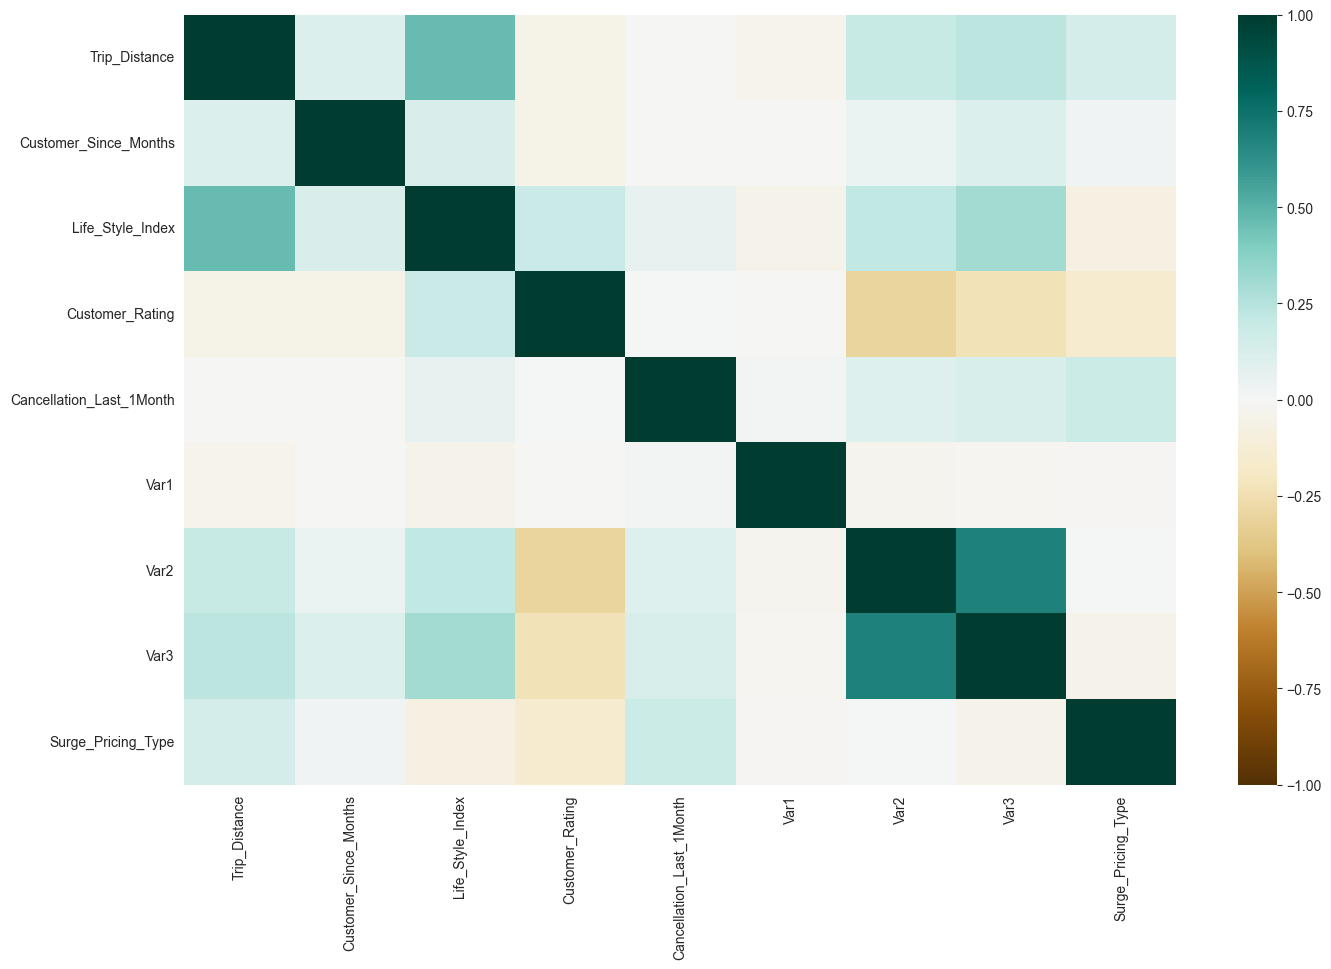

In [85]:
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(),
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [86]:
def get_redundant_pairs(data_frame: pd.DataFrame):
    pairs_to_drop = set()
    cols = data_frame.columns
    for i in range(0, data_frame.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(data_frame: pd.DataFrame, n: int = 5):
    au_corr = data_frame.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data_frame)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [87]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns]))

Top Absolute Correlations
Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64


### Training

In [88]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop(columns=['Surge_Pricing_Type'])
y = df['Surge_Pricing_Type']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [90]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Your code is here
pipe_one_all = Pipeline([("scaler", StandardScaler()),
                         ("one_vs_all", OneVsRestClassifier(LogisticRegression()))])

pipe_one_all.fit(X_train, y_train)

report = classification_report(y_true=y_test,
                               y_pred=pipe_one_all.predict(X_test),
                               digits=3,
                               output_dict=False,
                               )
print(report)

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [91]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [92]:
### Your code is here
from sklearn.model_selection import GridSearchCV

search1 = GridSearchCV(estimator=pipe_one_all,
                       param_grid=param_grid,
                       scoring='accuracy')

search1.fit(X=X_train, y=y_train)
print(f"Best parameters: {search1.best_params_}")
print(search1.best_params_)

Best parameters: {'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}
{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}


In [93]:
best_model = search1.best_estimator_
report = classification_report(y_true=y_test,
                               y_pred=best_model.predict(X_test),
                               digits=3,
                               output_dict=False,
                               )
print(report)

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

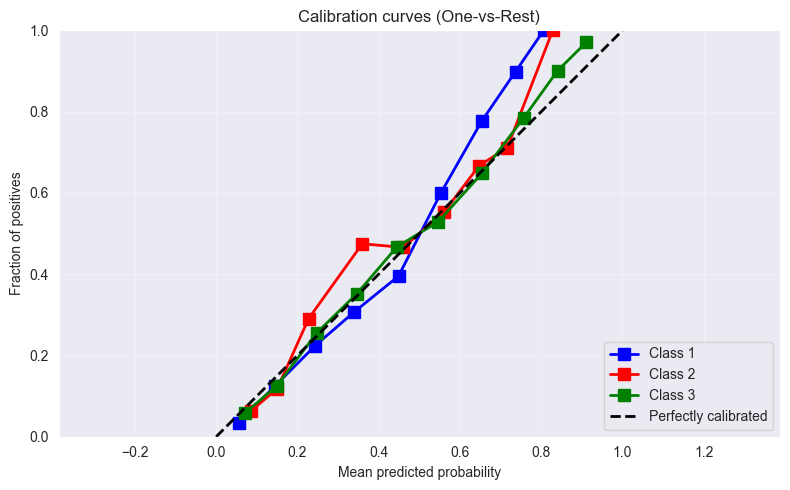

In [94]:
### Your code is here
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))

prob = best_model.predict_proba(X_test)
num_classes = 3
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range(num_classes):
    y_true_binary = (y_test == i + 1).astype(int)
    y_prob_binary = prob[:, i]
    prob_true, prob_pred = calibration_curve(
        y_true_binary,
        y_prob_binary,
        n_bins=10,
    )
    plt.plot(prob_pred,
             prob_true,
             's-',
             label=f'Class {i + 1}',
             color=colors[i % len(colors)],
             linewidth=2,
             markersize=8)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [96]:
numeric_columns

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')

In [98]:
### Создание полиномиальных признаков

X_polinomial = X.copy()
for col in numeric_columns.drop('Surge_Pricing_Type'):
    for i in range(3):
        X_polinomial[f"{col}_{i + 2}"] = X_polinomial[col] ** (i + 2)

### Your code is here

In [103]:
X_pol_train, X_pol_test, y_train, y_test = train_test_split(X_polinomial, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=2022)

In [104]:
### Your code is here
search2 = GridSearchCV(estimator=pipe_one_all,
                       param_grid=param_grid,
                       scoring='accuracy')

search2.fit(X=X_pol_train, y=y_train)
print(classification_report(y_true=y_test,
                            y_pred=search2.predict(X_pol_test),
                            digits=3,
                            output_dict=False,
                            ))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

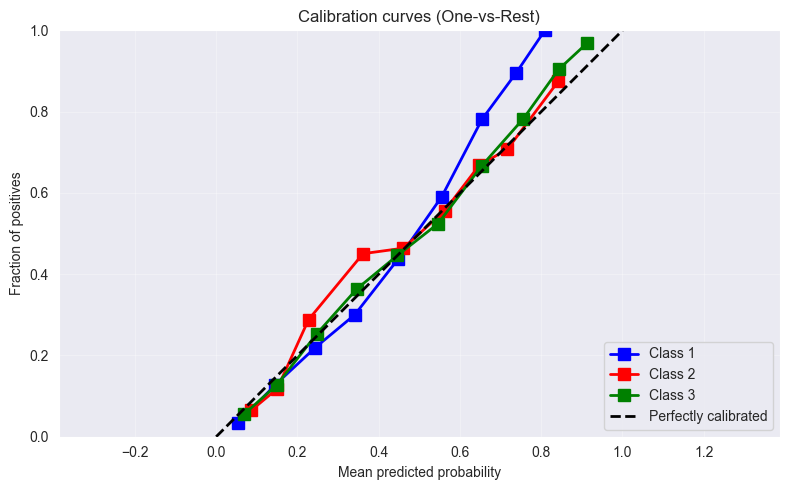

In [105]:
### Your code is here
plt.figure(figsize=(8, 5))

prob = search2.predict_proba(X_pol_test)
num_classes = 3
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i in range(num_classes):
    y_true_binary = (y_test == i + 1).astype(int)
    y_prob_binary = prob[:, i]
    prob_true, prob_pred = calibration_curve(
        y_true_binary,
        y_prob_binary,
        n_bins=10,
    )
    plt.plot(prob_pred,
             prob_true,
             's-',
             label=f'Class {i + 1}',
             color=colors[i % len(colors)],
             linewidth=2,
             markersize=8)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


In [106]:
X_polinomial.shape

(131662, 52)

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2022)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe_all_all = Pipeline([("scaler", StandardScaler()),
                         ("all_vs_all", OneVsOneClassifier(SGDClassifier()))])
pipe_all_all.fit(X_train, y_train)

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [116]:
param_grid = {'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'all_vs_all__estimator__penalty': ['l1', 'l2'],
              'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1]}

In [120]:
### Your code is here
search3 = GridSearchCV(estimator=pipe_all_all,
                       param_grid=param_grid,
                       scoring='accuracy')
search3.fit(X=X_train, y=y_train)
print(f"Best parameter {search3.best_params_}")
print(classification_report(y_true=y_test,
                            y_pred=search3.predict(X_test),
                            digits=3,
                            output_dict=False,
                            ))

Best parameter {'all_vs_all__estimator__alpha': 0.1, 'all_vs_all__estimator__loss': 'modified_huber', 'all_vs_all__estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           1      0.748     0.529     0.620      5372
           2      0.632     0.845     0.724     11349
           3      0.745     0.570     0.646      9612

    accuracy                          0.681     26333
   macro avg      0.708     0.648     0.663     26333
weighted avg      0.697     0.681     0.674     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?